In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os



In [2]:
def load_dataset(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        class_label = 1 if class_name == 'uninfected' else 0
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(class_label)
    return np.array(images), np.array(labels)


In [3]:
# Load and split the data
train_dir = r'C:\Users\OMEN\Malaria_Project\notebook\data\Train'
X, y = load_dataset(train_dir)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X shape: (27558, 224, 224, 3)
y shape: (27558,)
X_train shape: (22046, 224, 224, 3)
y_train shape: (22046,)
X_val shape: (5512, 224, 224, 3)
y_val shape: (5512,)


In [8]:
# Check class distribution
train_infected = np.sum(y_train == 0)
train_uninfected = np.sum(y_train == 1)
val_infected = np.sum(y_val == 0)
val_uninfected = np.sum(y_val == 1)

print(f"Training set - Infected: {train_infected}, Uninfected: {train_uninfected}")
print(f"Validation set - Infected: {val_infected}, Uninfected: {val_uninfected}")


Training set - Infected: 10982, Uninfected: 11064
Validation set - Infected: 2797, Uninfected: 2715


In [14]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [15]:
# Create and compile the model
model = create_model()
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,489,729 (9.50 MB)

 Trainable params: 2,489,729 (9.50 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 512s 704ms/step - accuracy: 0.5946 - loss: 2.5555 - val_accuracy: 0.7284 - val_loss: 0.8593 - learning_rate: 1.0000e-04
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 397s 576ms/step - accuracy: 0.8149 - loss: 0.7505 - val_accuracy: 0.9198 - val_loss: 0.5141 - learning_rate: 1.0000e-04
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 401s 582ms/step - accuracy: 0.9150 - loss: 0.5127 - val_accuracy: 0.9245 - val_loss: 0.4423 - learning_rate: 1.0000e-04
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 401s 582ms/step - accuracy: 0.9192 - loss: 0.4586 - val_accuracy: 0.9198 - val_loss: 0.4117 - learning_rate: 1.0000e-04
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 404s 586ms/step - accuracy: 0.9174 - loss: 0.4276 - val_accuracy: 0.9271 - val_loss: 0.3861 - learning_rate: 1.0000e-04
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 413s 600ms/step - accuracy: 0.9263 - loss: 0.3898 - val_accuracy: 0.9227 - val_loss: 0.3744 - learning_rate: 1.0000e-04
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 

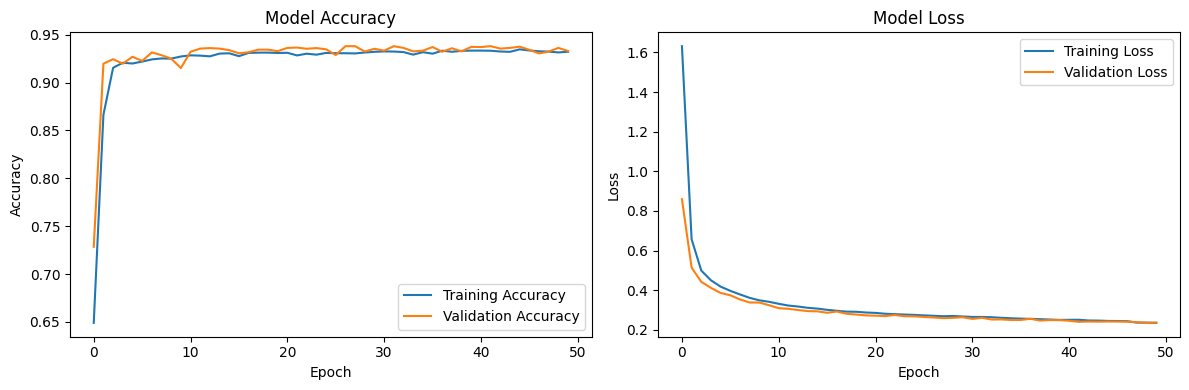

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Processing image: C3thin_original_IMG_20150608_163002_cell_63.png


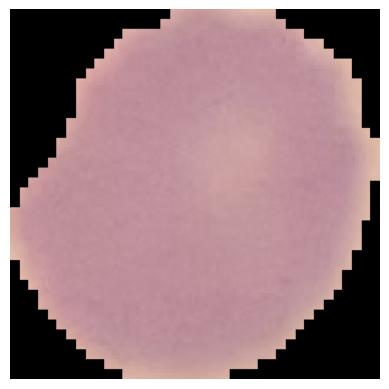

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_101.png


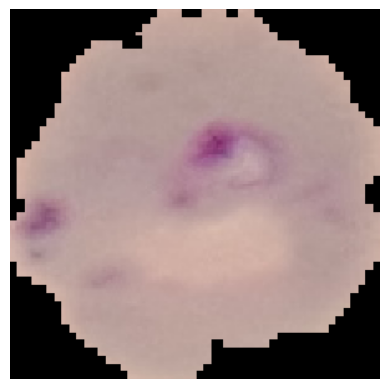

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_109.png


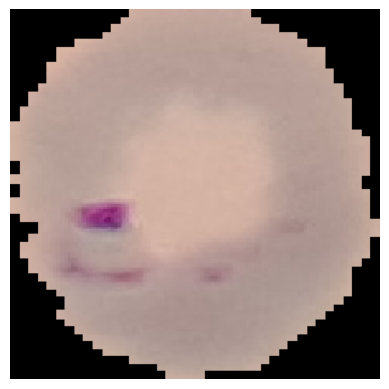

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163029_cell_220.png


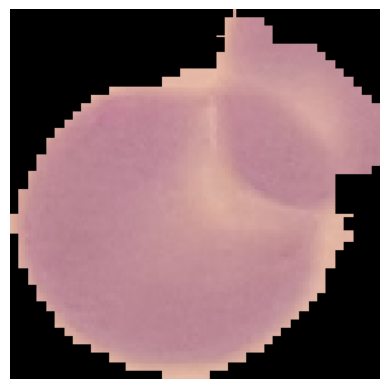

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_83.png


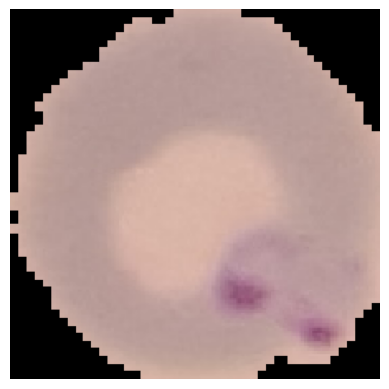

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_23.png


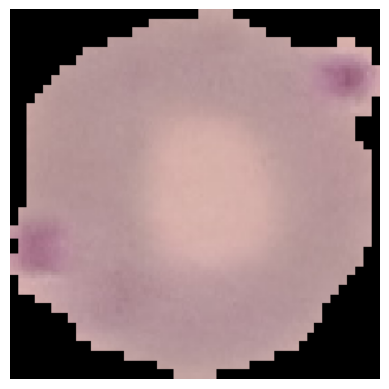

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_104.png


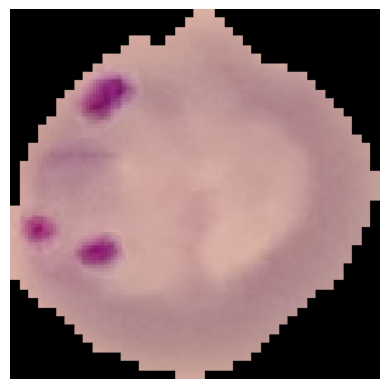

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_84.png


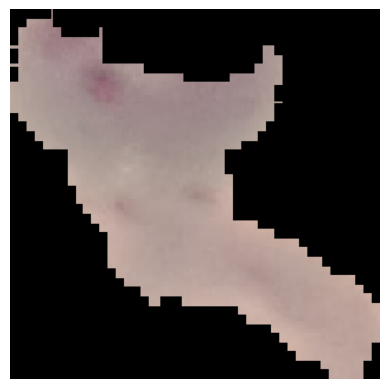

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_115.png


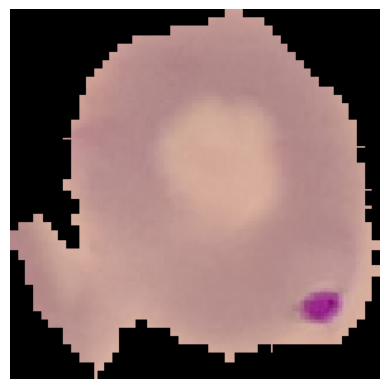

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163002_cell_195.png


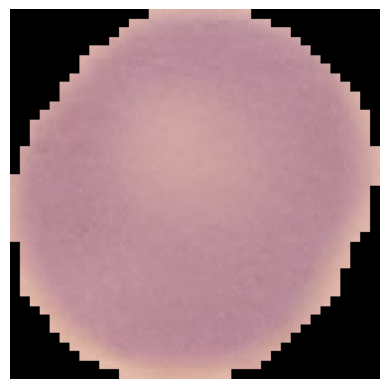

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_125.png


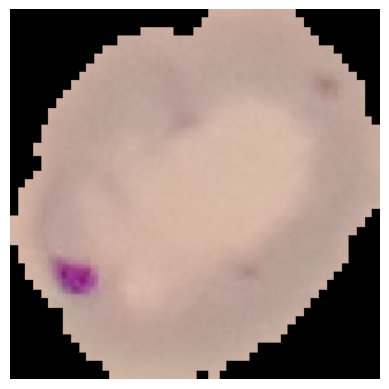

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_168.png


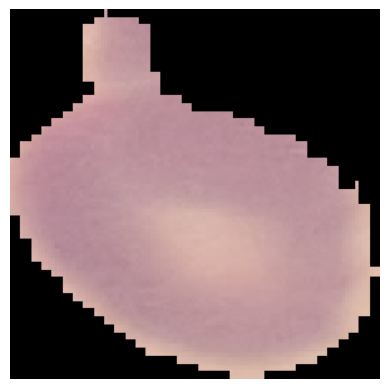

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_121.png


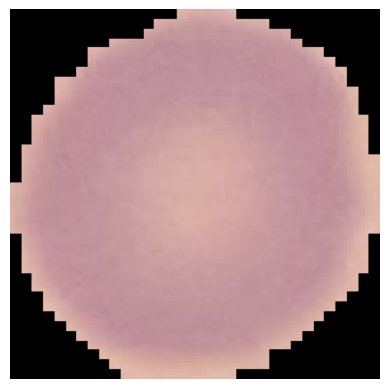

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110352_cell_79.png


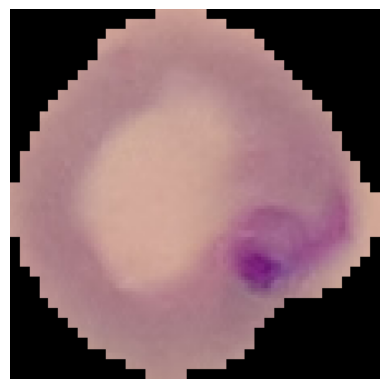

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163029_cell_52.png


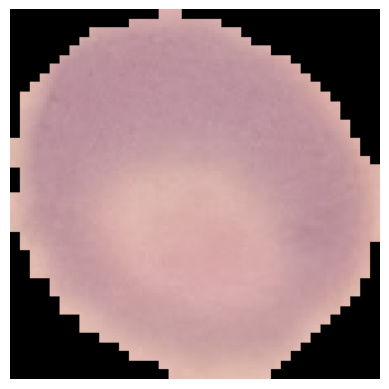

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_32.png


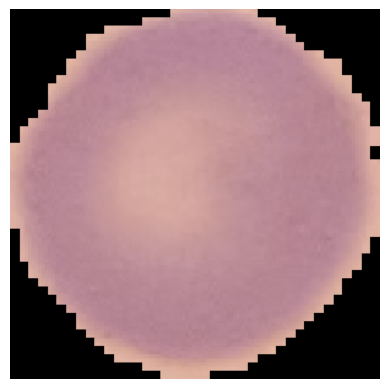

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_80.png


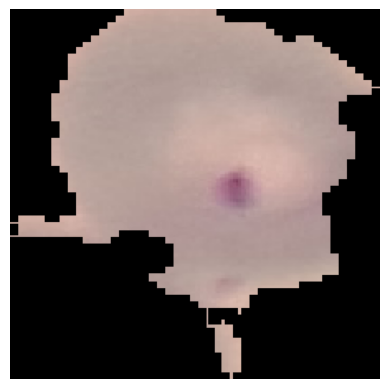

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_44.png


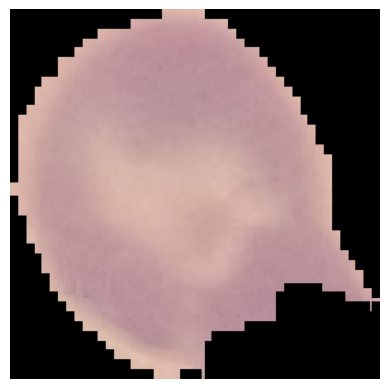

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_186.png


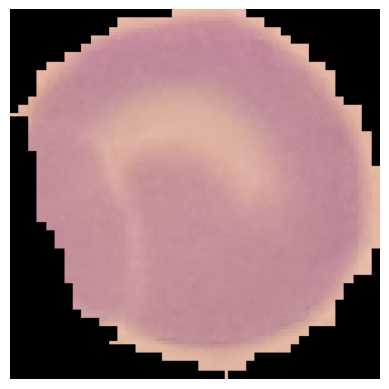

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_95.png


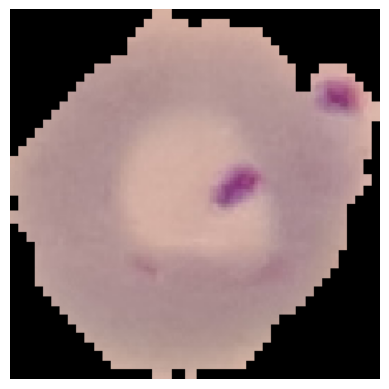

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_90.png


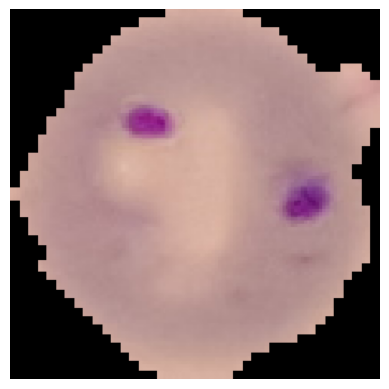

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_18.png


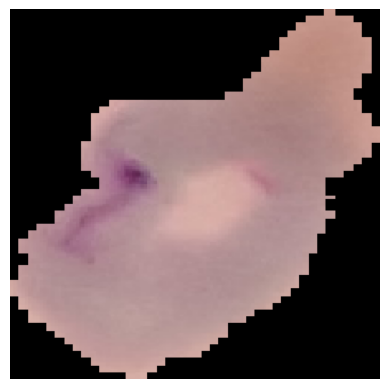

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163002_cell_34.png


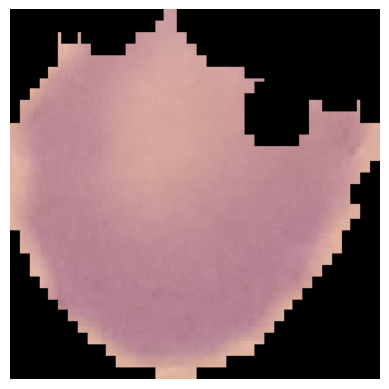

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_12.png


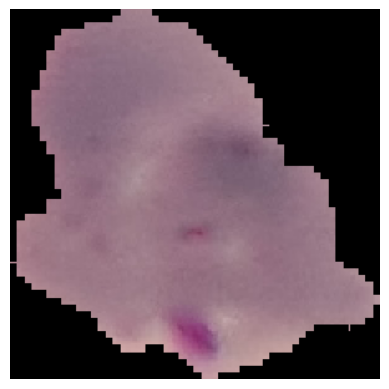

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_87.png


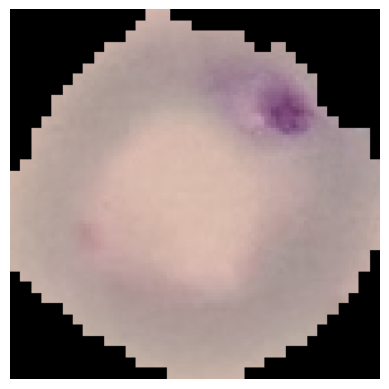

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_131.png


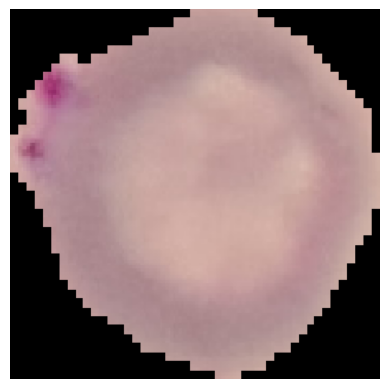

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_98.png


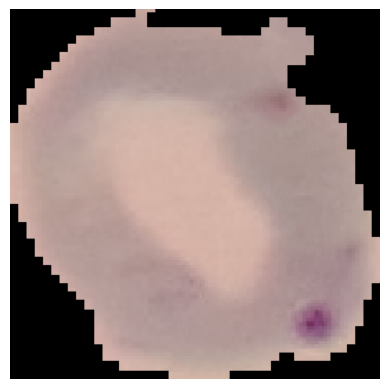

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163047_cell_183.png


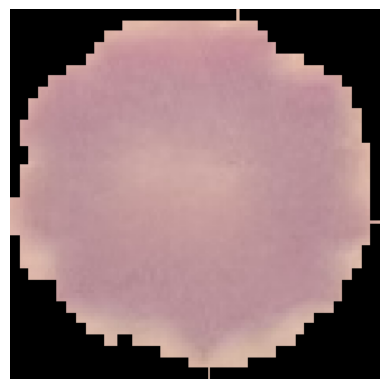

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_132.png


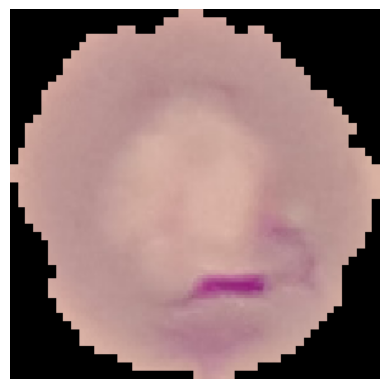

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_94.png


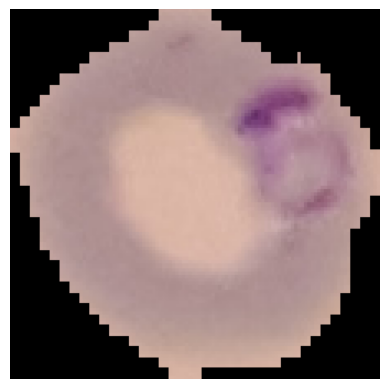

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_145.png


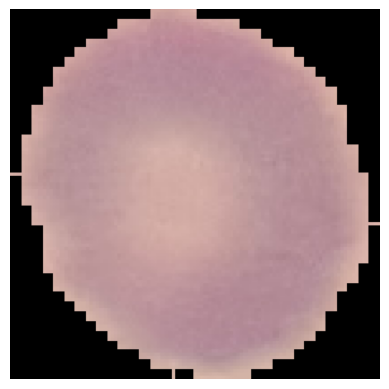

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_57.png


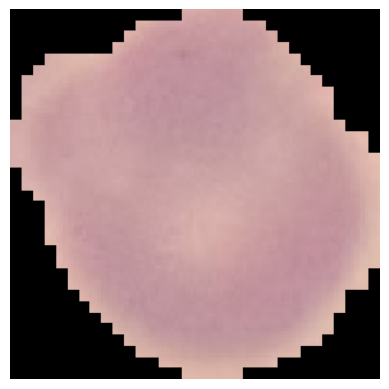

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_107.png


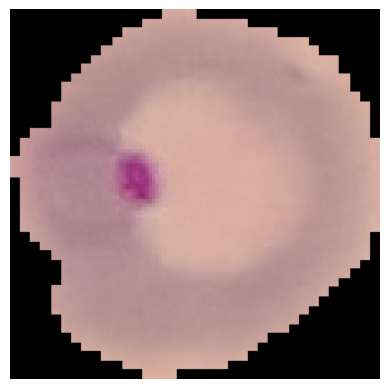

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_137.png


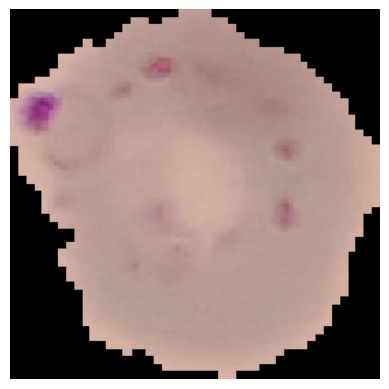

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_124.png


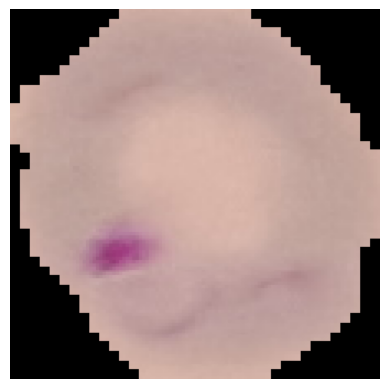

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_136.png


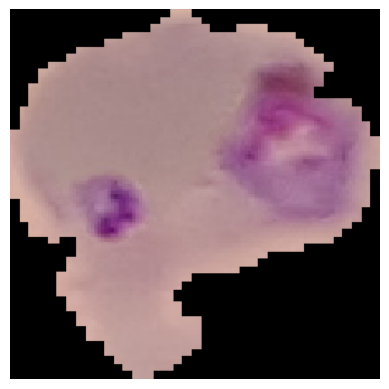

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_22.png


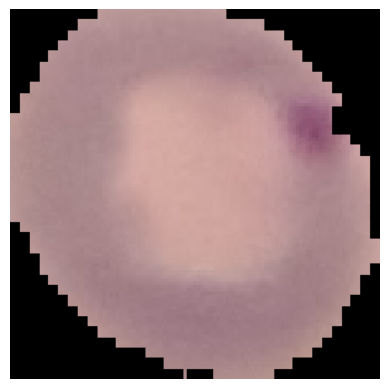

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_111.png


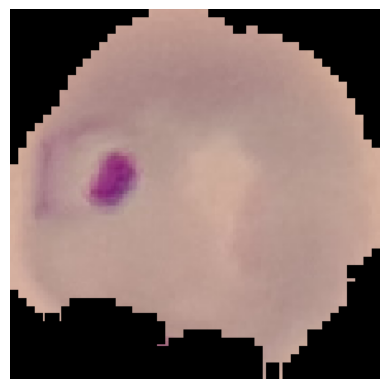

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_117.png


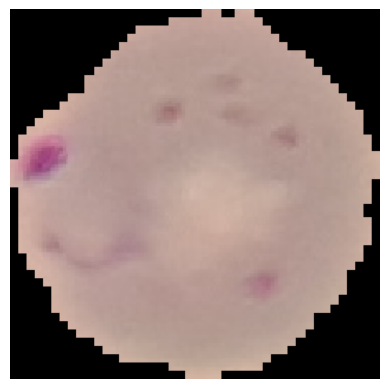

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_102.png


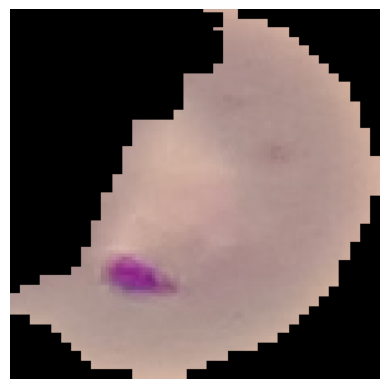

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_103.png


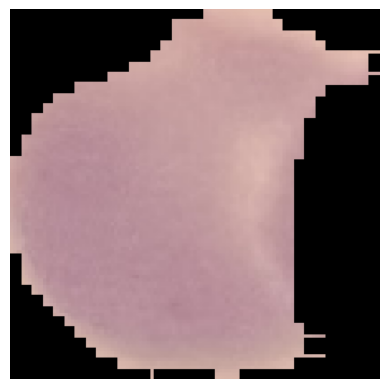

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_100.png


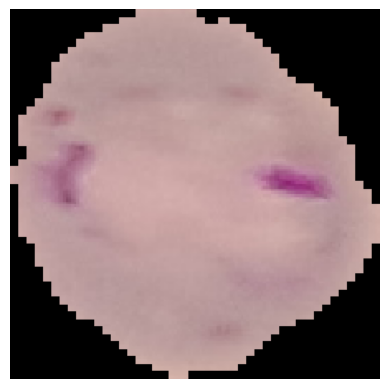

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_162922_cell_191.png


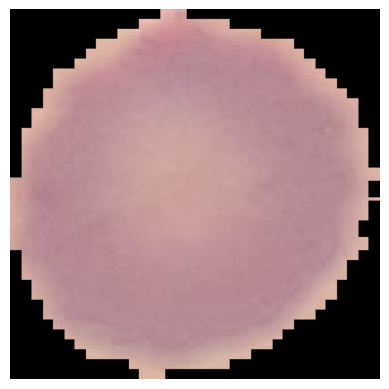

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_156.png


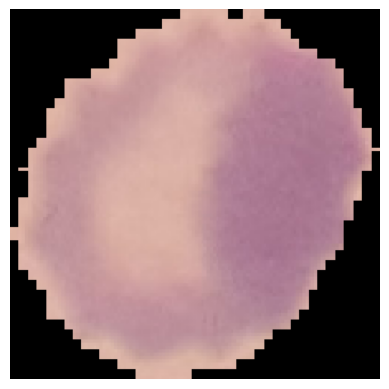

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_135.png


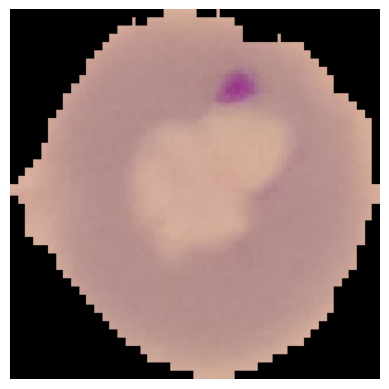

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_134.png


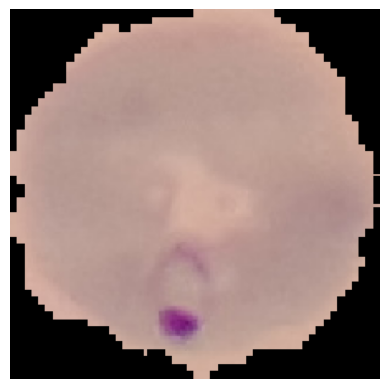

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_119.png


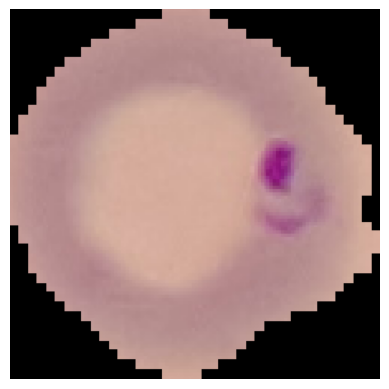

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_112.png


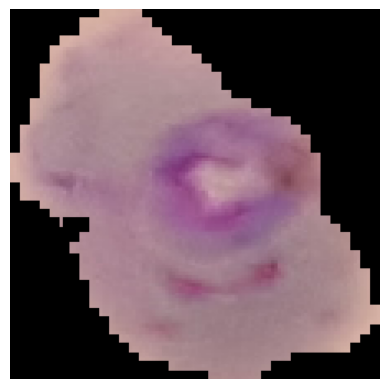

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_116.png


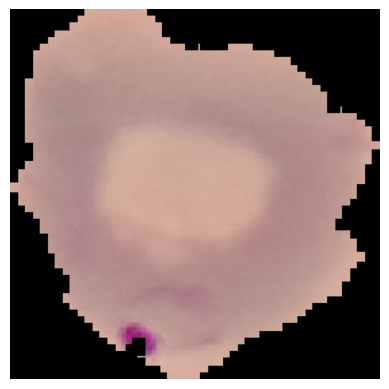

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_104.png


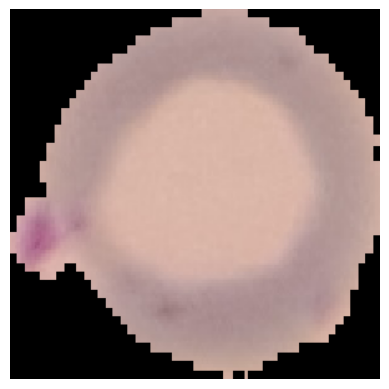

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_13.png


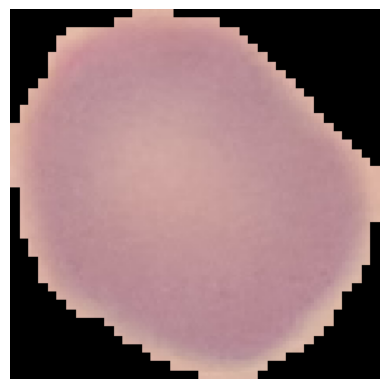

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_92.png


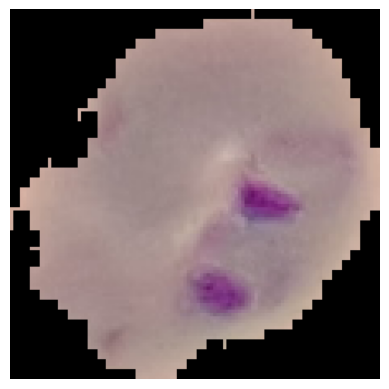

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163029_cell_109.png


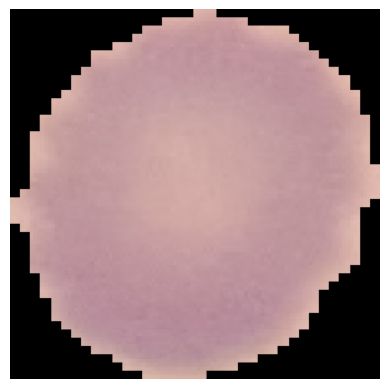

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_129.png


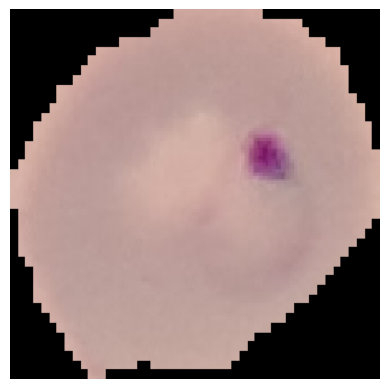

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_105.png


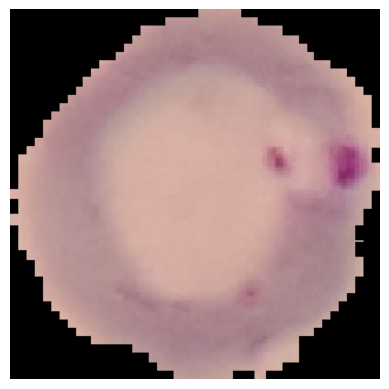

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_128.png


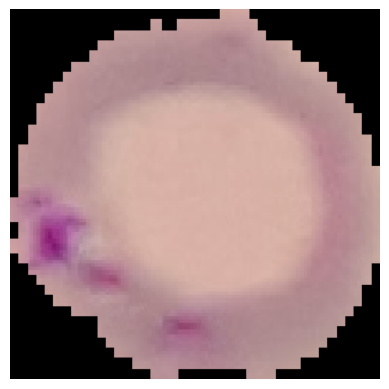

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_118.png


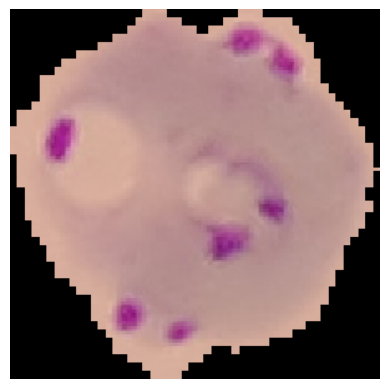

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_89.png


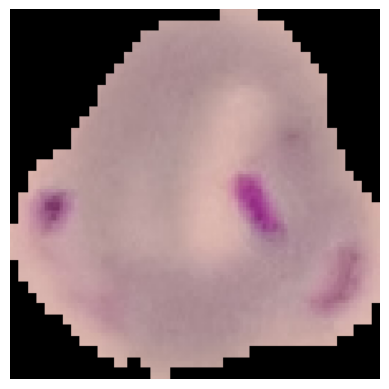

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_107.png


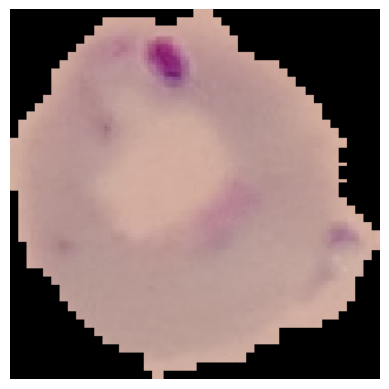

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_147.png


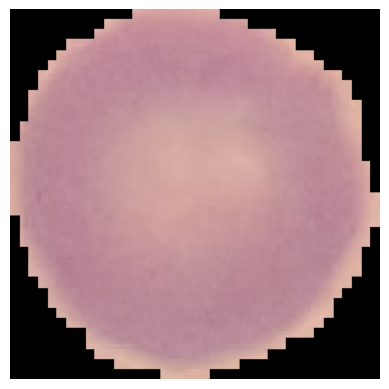

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_109.png


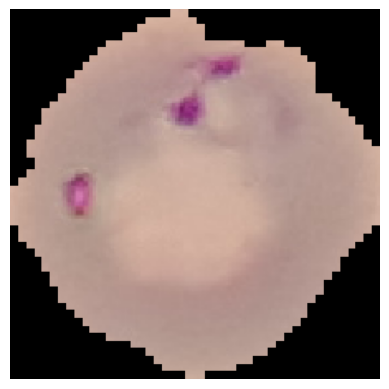

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_113.png


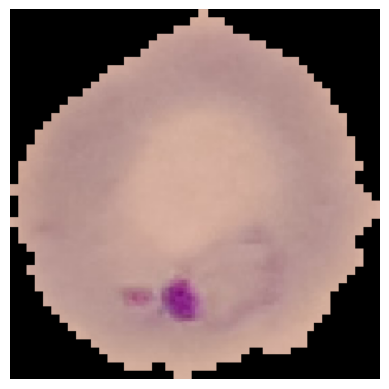

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_162922_cell_211.png


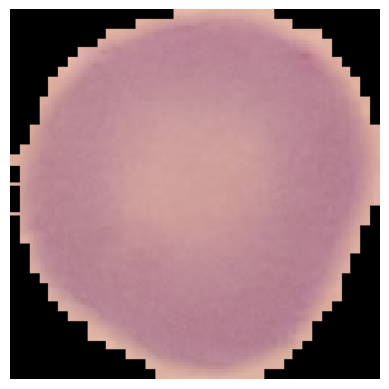

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_24.png


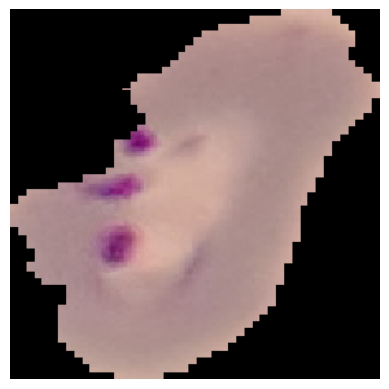

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_162922_cell_145.png


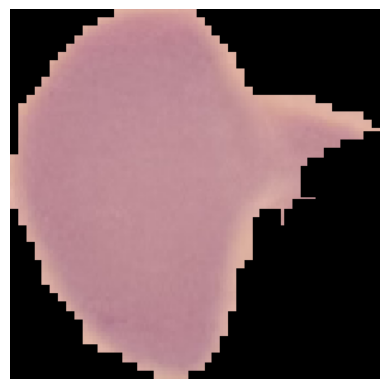

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_97.png


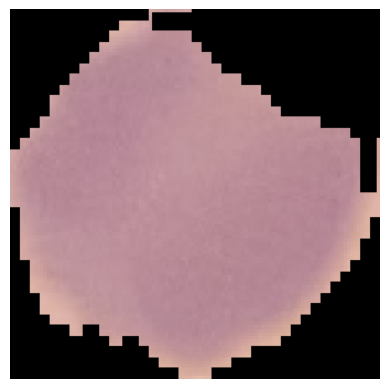

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_144.png


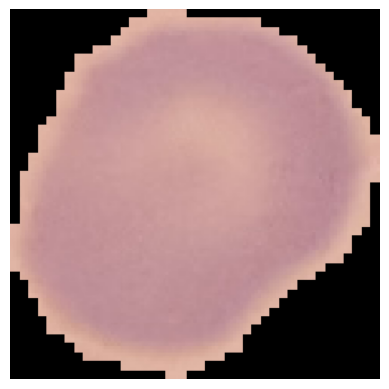

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_19.png


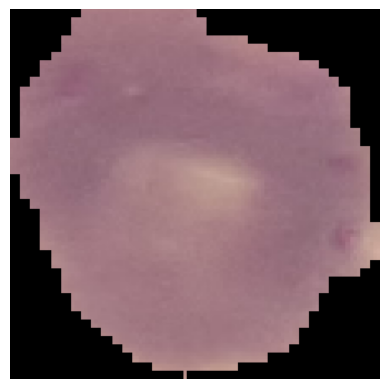

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_25.png


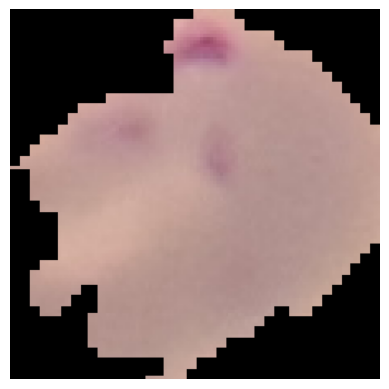

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_133.png


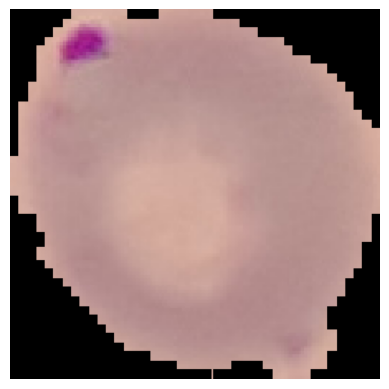

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163002_cell_159.png


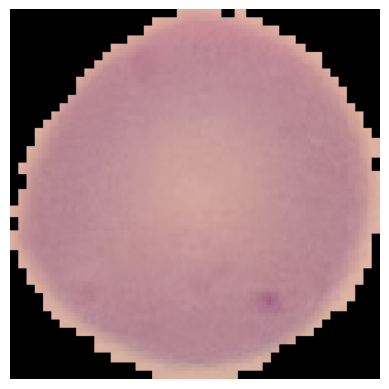

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_17.png


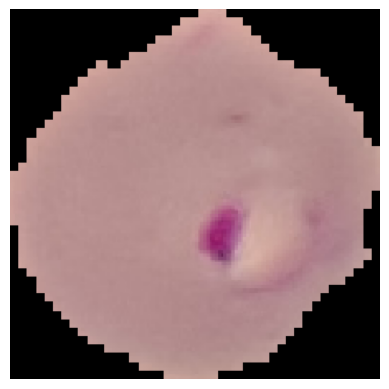

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163029_cell_125.png


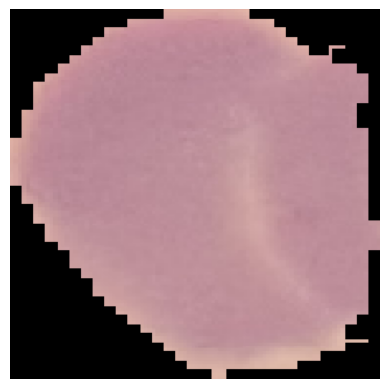

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_166.png


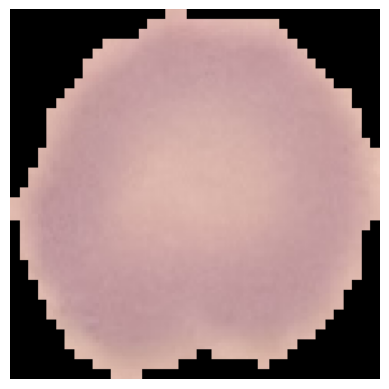

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_138.png


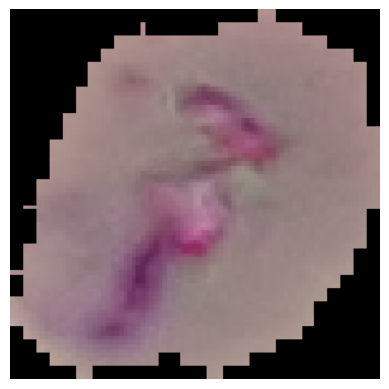

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_82.png


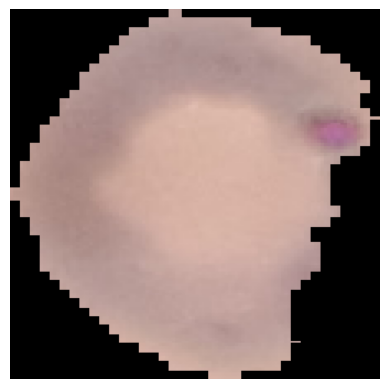

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_80.png


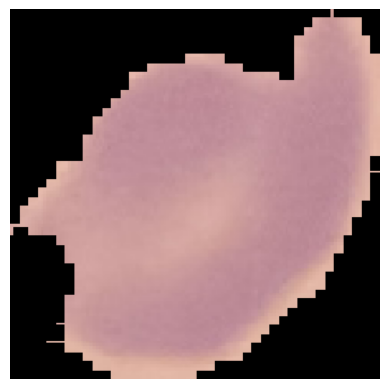

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_121.png


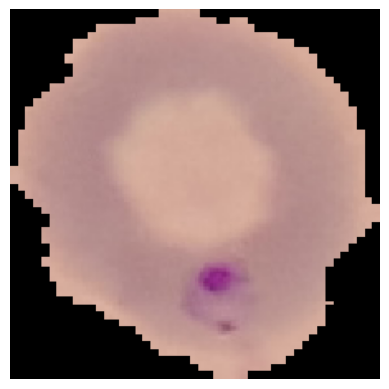

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_26.png


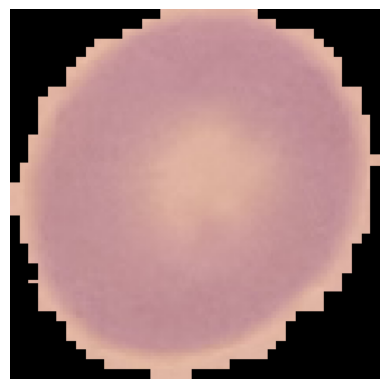

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_99.png


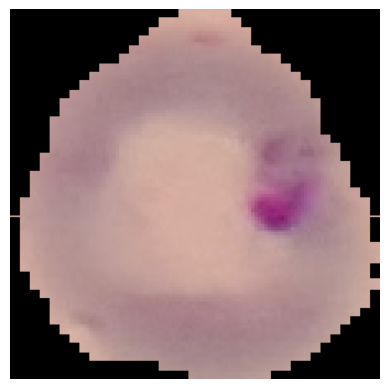

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163002_cell_93.png


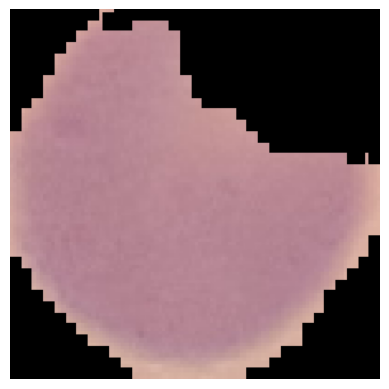

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_114.png


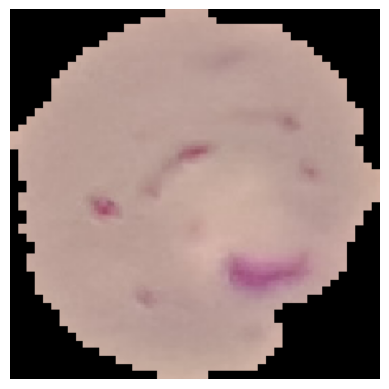

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_21.png


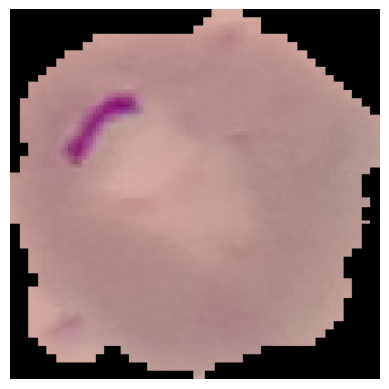

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163029_cell_1.png


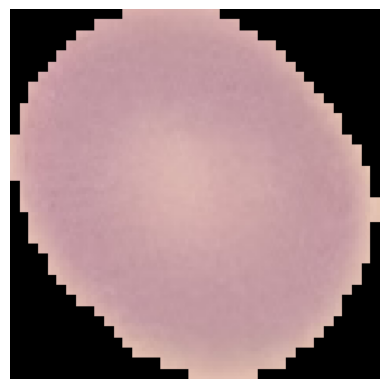

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_110.png


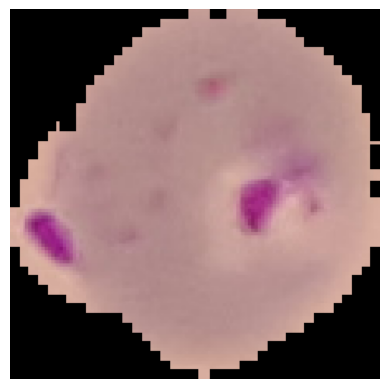

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_9.png


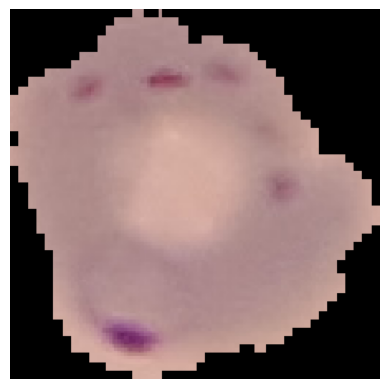

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_36.png


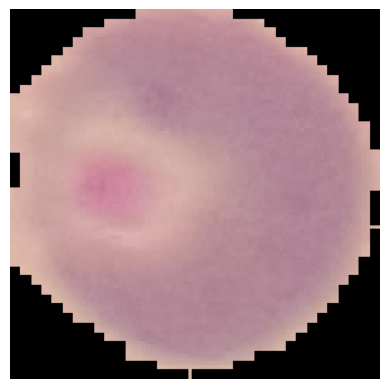

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_11.png


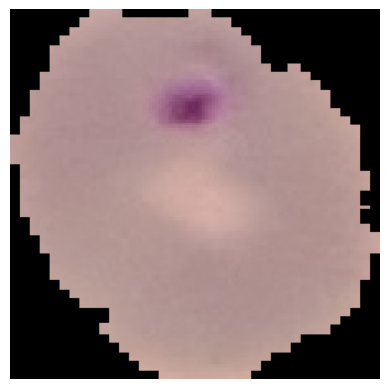

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_103.png


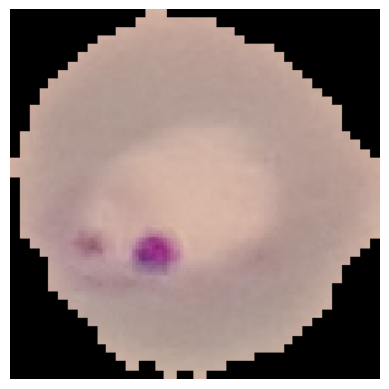

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_161.png


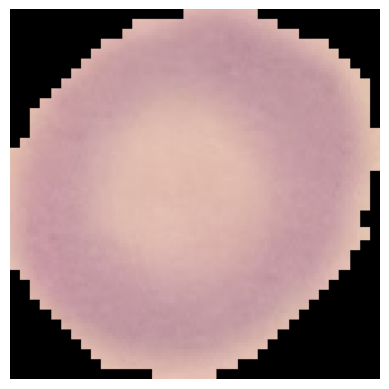

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_127.png


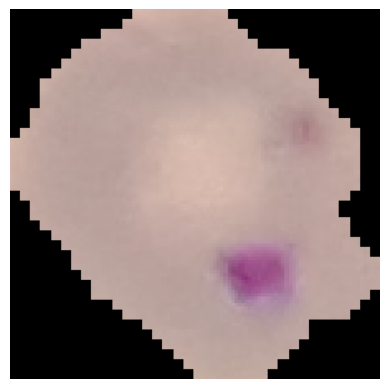

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_123.png


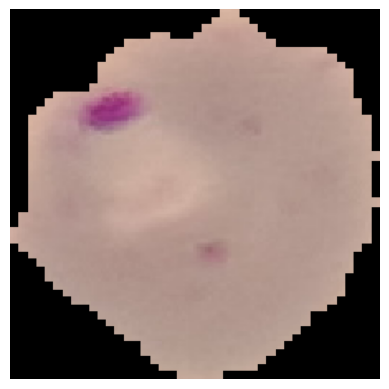

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_108.png


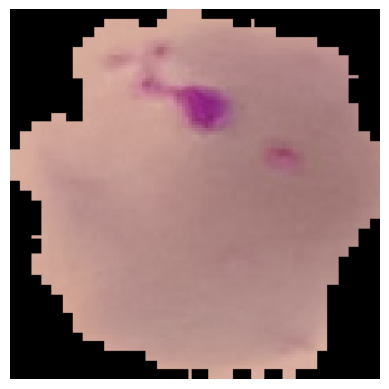

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_93.png


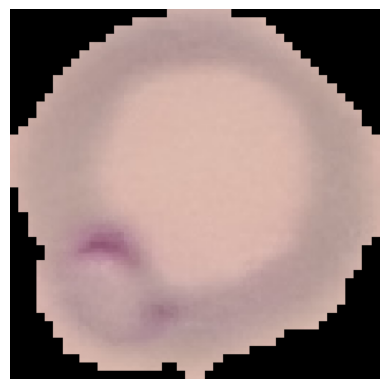

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_78.png


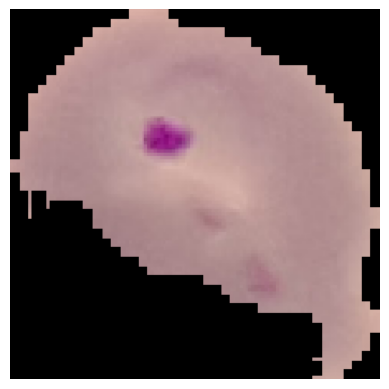

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_86.png


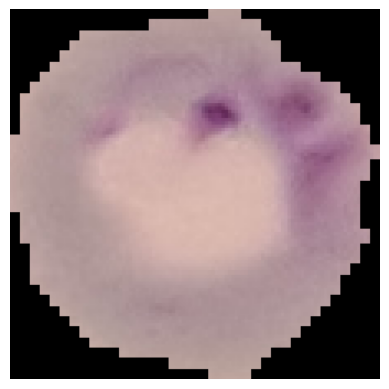

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_96.png


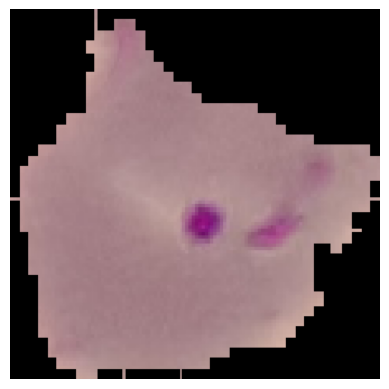

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163002_cell_81.png


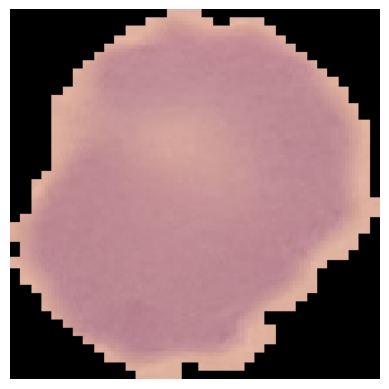

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_162922_cell_205.png


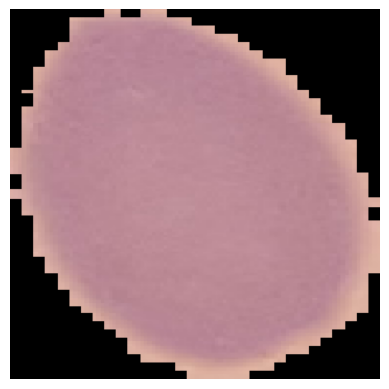

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_106.png


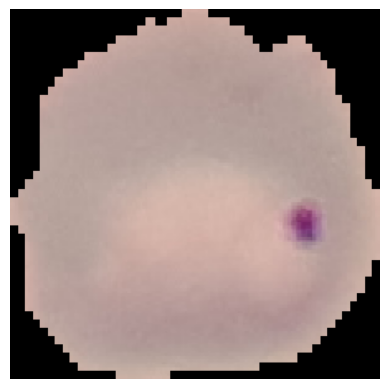

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: infected

Summary of Results:
Image: C3thin_original_IMG_20150608_163002_cell_63.png, Probability of being uninfected: 0.9606
Image: C39P4thinF_original_IMG_20150622_105803_cell_101.png, Probability of being uninfected: 0.0893
Image: C39P4thinF_original_IMG_20150622_105803_cell_109.png, Probability of being uninfected: 0.0597
Image: C3thin_original_IMG_20150608_163029_cell_220.png, Probability of being uninfected: 0.9225
Image: C39P4thinF_original_IMG_20150622_105803_cell_83.png, Probability of being uninfected: 0.8505
Image: C39P4thinF_original_IMG_20150622_105554_cell_23.png, Probability of being uninfected: 0.9624
Image: C39P4thinF_original_IMG_20150622_110115_cell_104.png, Probability of being uninfected: 0.0622
Image: C39P4thinF_original_IMG_20150622_105803_cell_84.png, Probability of being uninfected: 0.6081
Image: C39P4thinF_original_IMG_20150622_110115_cell_115.png, Probability of being uninfected: 0.0778
Image: C3thin_original_I

c:\Users\OMEN\Malaria_Project\new_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


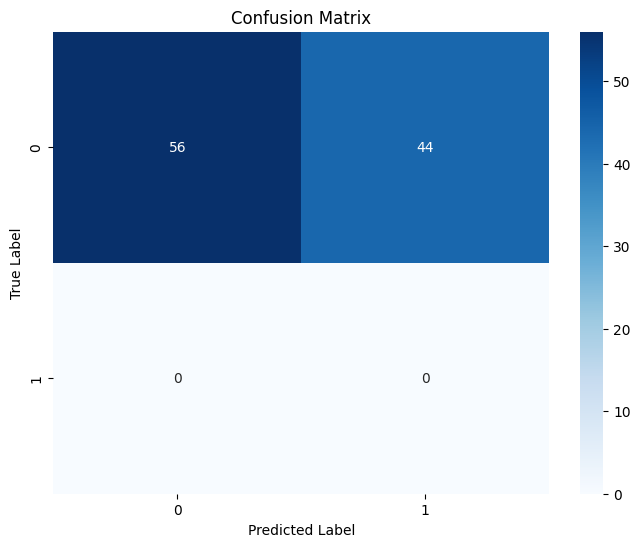

In [22]:

# Path to your test directory
dir_path = r'C:\Users\OMEN\Malaria_Project\notebook\data\Test'

# Function to predict and display results
def predict_and_display(model, img_path, target_size=(224, 224)):
    try:
        img = image.load_img(img_path, target_size=target_size)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        X = image.img_to_array(img)
        X = X / 255.0  # Normalize the image
        X = np.expand_dims(X, axis=0)
        
        val = model.predict(X)

        prediction = "uninfected" if val[0][0] > 0.5 else "infected"
        print(f"Predicted: {prediction}")

        return val[0][0]
    except Exception as e:
        print(f"Error processing image {img_path}: {str(e)}")
        return None

# Get list of all images and randomly select 100
all_images = os.listdir(dir_path)
selected_images = random.sample(all_images, min(100, len(all_images)))

# Process selected images
results = []
true_labels = []
for i in selected_images:
    img_path = os.path.join(dir_path, i)
    print(f"\nProcessing image: {i}")
    probability = predict_and_display(model, img_path)
    if probability is not None:
        results.append({'image': i, 'probability': probability})
        # Assuming the true label is in the filename (e.g., "infected_001.png")
        true_label = 1 if "uninfected" in i.lower() else 0
        true_labels.append(true_label)

# Display summary of results
print("\nSummary of Results:")
for result in results:
    print(f"Image: {result['image']}, Probability of being uninfected: {result['probability']:.4f}")

# Calculate overall statistics
predicted_labels = [1 if r['probability'] > 0.5 else 0 for r in results]

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"\nTotal images processed: {len(results)}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()